# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `numpy`: Gestione di array e funzioni di calcolo.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [26]:
"""
Install dependencies:
>>> pip install --update pip
>>> pip install numpy pandas matplotlib seaborn scikit-learn
"""

'\nInstall dependencies:\n>>> pip install --update pip\n>>> pip install numpy pandas matplotlib seaborn scikit-learn\n'

In [27]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder as le

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
* `num_epochs`: Numero di epoche di training del modello (usato anche nella fase di valutazione nel test set).

In [28]:
net_layers = [ [32, 'relu'] for _ in range(2) ] + [[64, 'relu'] for _ in range(10)] + [ [32, 'relu'] ]
num_epochs = 25                                  # Number of epochs

# 2: Dataset augmentation function


In [29]:
def dataset_augmentation(dataset: pd.DataFrame, target_count = 1000):

    old_samples = dataset[dataset['Age'] == 'Old'].copy() # filter 'Old' samples
    
    # check if there are any 'Old' samples
    if len(old_samples) == 0:
        return dataset
    
    print(f"Campioni 'Old' originali: {len(old_samples)}")
    print(f"Target campioni 'Old':    {target_count}")

    num_cols = old_samples.keys()[1 : -1] # skip first and last column (not numeric features)
    
    synthetic_samples = []
    samples_needed    = target_count - len(num_cols)
    
    for _ in range(samples_needed):

        base_sample = old_samples.sample(n = 1).iloc[0].copy() # base sample from 'Old' samples
        
        for col in num_cols: # add noise to numeric columns
            noise_factor     = np.random.uniform(0.02, 0.08)
            noise            = np.random.normal(0, base_sample[col] * noise_factor)
            base_sample[col] = max(0, base_sample[col] + noise) # ensure no negative values
        
        synthetic_samples.append(base_sample) # append modified sample to list
    
    # convert list of synthetic samples to DataFrame
    synthetic_df      = pd.DataFrame(synthetic_samples)
    augmented_dataset = pd.concat([dataset, synthetic_df], ignore_index = True)
    
    print(f"Campioni sintetici creati: {len(synthetic_samples)}")
    print(f"Nuova dimensione dataset:  {len(augmented_dataset)}")
    
    return augmented_dataset # return augmented dataset with synthetic samples

# 3: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi: **4177** istanze
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [30]:
try:
  
  dataset = pd.read_csv("./Dataset.csv") # load the dataset

  dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'
  dataset        = dataset_augmentation(dataset, target_count=1000) # Dataset augmentation

  # One-hot encoding for column 'Age'
  column     = 'Age'
  dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
  dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

  # Separate features and labels
  Y = dataset[dummy_cols]
  X = dataset.drop(columns = dummy_cols)

  # First split: 70% train, 30% combined validation and test
  X_train, X_combined, Y_train, Y_combined = train_test_split(X, Y, test_size = 0.3, random_state = 42)

  # Second split: 65% validation, 35% test from the 30% combined set
  X_val, X_test, Y_val, Y_test = train_test_split(X_combined, Y_combined, test_size = 0.35, random_state = 42)

  print("Training set shape:  ", X_train.shape, Y_train.shape)
  print("Validation set shape:", X_val.shape, Y_val.shape)
  print("Test set shape:      ", X_test.shape, Y_test.shape)
except FileNotFoundError:
  
  print("Errore, file non trovato")

Campioni 'Old' originali: 36
Target campioni 'Old':    1000
Campioni sintetici creati: 993
Nuova dimensione dataset:  5170
Training set shape:   (3619, 8) (3619, 3)
Validation set shape: (1008, 8) (1008, 3)
Test set shape:       (543, 8) (543, 3)


# 4: Creazione del modello
Generazione di un modello di rete neurale.

In [31]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))]) # Input layer

for layer in net_layers: # Add hidden layers
    model.add(layers.Dense(layer[0], activation = layer[1]))
    model.add(layers.Dropout(0.2)) # Dropout layer to prevent overfitting
    model.add(layers.BatchNormalization()) # Batch normalization layer
    
model.add(layers.Dense(Y_train.shape[1], activation='softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 46,019 (179.76 KB)

 Trainable params: 44,547 (174.01 KB)

 Non-trainable params: 1,472 (5.75 KB)

## 5: Compilazione e training del modello generato

In [32]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss      = 'categorical_crossentropy', 
    metrics   = ['accuracy', 'Precision', 'Recall']
)

history = model.fit(
    X_train, Y_train,
    epochs          = num_epochs, # Number of epochs
    batch_size      = 32, # Batch size
    validation_data = (X_val, Y_val)
)

Epoch 1/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - Precision: 0.3405 - Recall: 0.2582 - accuracy: 0.3321 - loss: 1.4701 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3869 - val_loss: 1.0794
Epoch 2/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.3996 - Recall: 0.2528 - accuracy: 0.3831 - loss: 1.2214 - val_Precision: 0.3953 - val_Recall: 0.3313 - val_accuracy: 0.3869 - val_loss: 1.1165
Epoch 3/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.4006 - Recall: 0.2158 - accuracy: 0.3839 - loss: 1.1564 - val_Precision: 0.4227 - val_Recall: 0.1925 - val_accuracy: 0.3869 - val_loss: 1.0879
Epoch 4/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.4451 - Recall: 0.2241 - accuracy: 0.4172 - loss: 1.1131 - val_Precision: 0.4138 - val_Recall: 0.2550 - val_accuracy: 0.3879 - val_loss: 1.0972
Epoch 5/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.4552 - Recall: 0.2136 - accuracy: 0.4337 - loss: 1.0750 - val_Precision: 0.3981 - 

## 6: Visualizzazione dei risultati

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.4629 - Recall: 0.3860 - accuracy: 0.4423 - loss: 0.9883
Test set evaluation:
Loss:     0.9888
Accuracy: 0.4604


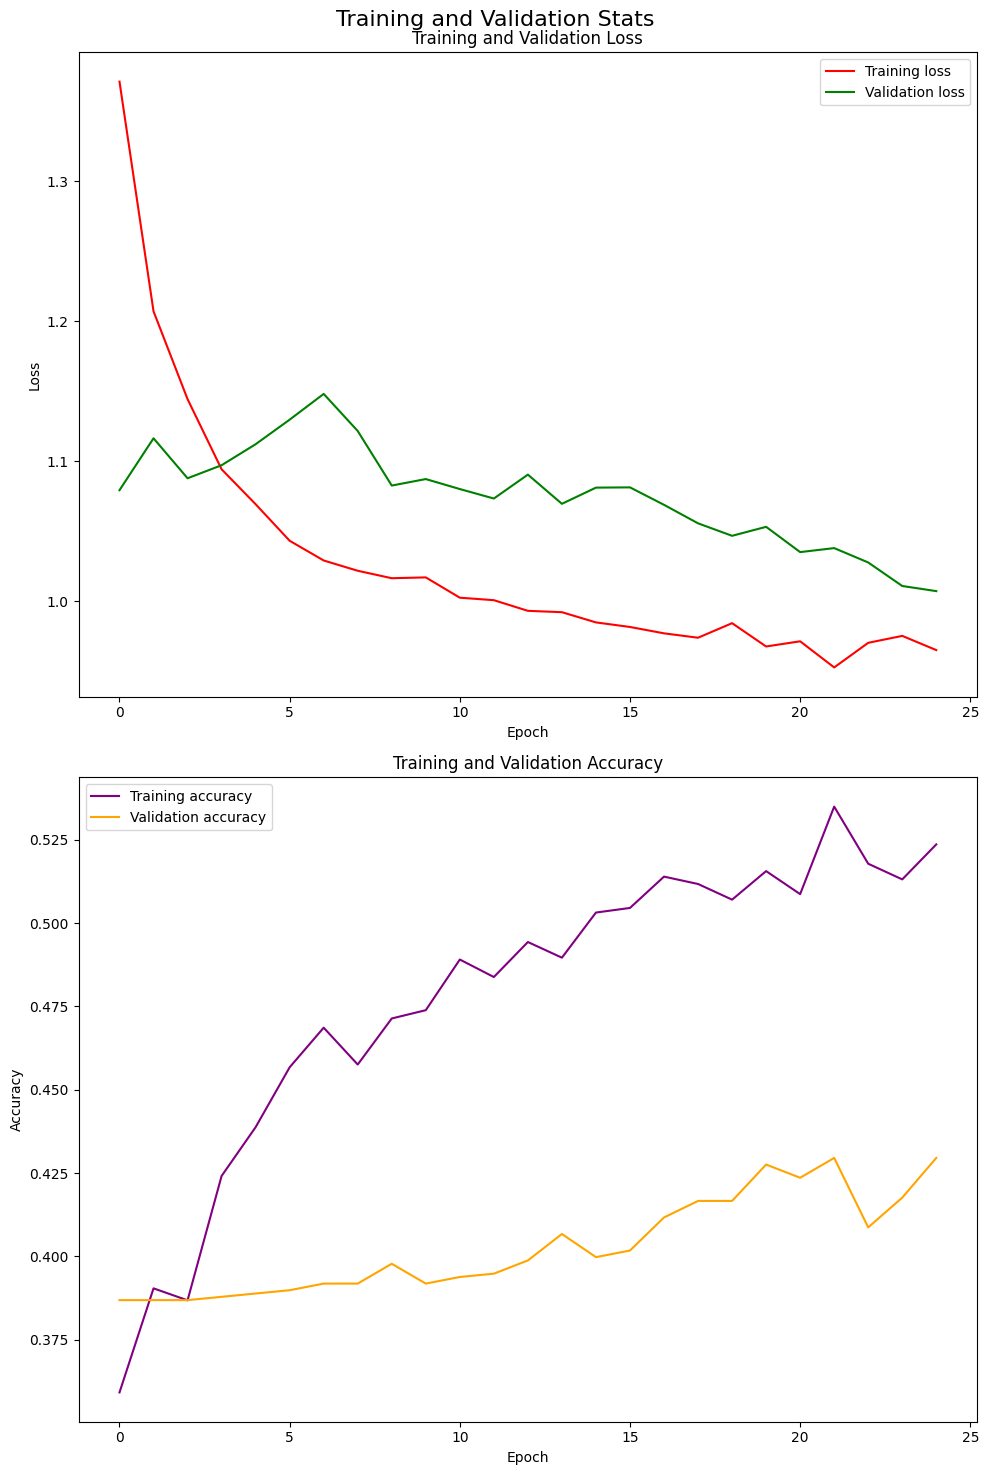

In [33]:
new_history = model.evaluate(X_test, Y_test, steps = num_epochs, return_dict = True) # Evaluate the model on the test set

print("Test set evaluation:") # this is probably not correct
print(f"Loss:     {new_history['loss']:.4f}")
print(f"Accuracy: {new_history['accuracy']:.4f}")

fig, plots = plt.subplots(2, 1, figsize = (10, 15)) # Create a figure with 2 subplots
fig.suptitle('Training and Validation Stats', fontsize = 16)

# Training and validation loss
plots[0].set_title('Training and Validation Loss')
plots[0].plot(history.history['loss'],     label = 'Training loss',   color = 'red')
plots[0].plot(history.history['val_loss'], label = 'Validation loss', color = 'green')
plots[0].set_xlabel('Epoch')
plots[0].set_ylabel('Loss')
plots[0].legend()

# Training and validation accuracy
plots[1].set_title('Training and Validation Accuracy')
plots[1].plot(history.history['accuracy'],     label = 'Training accuracy',   color = 'purple')
plots[1].plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'orange')
plots[1].set_xlabel('Epoch')
plots[1].set_ylabel('Accuracy')
plots[1].legend()

fig.tight_layout() # Adjust layout to prevent overlap
plt.show()         # Show the plots